# HANDWRITTEN REGCONITION USING CNN + LSTM

## IMPORT LIBRARIES

In [0]:
import os
import fnmatch
import cv2
import numpy as np
import string
import time
import tensorflow.keras.backend as K

# make sure we use tensorflow 2.0
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

# import padding library
from tensorflow.keras.preprocessing.sequence import pad_sequences

# import our model, different layers and activation function 
from tensorflow.keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, sigmoid, softmax
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
import pathlib
import matplotlib.pyplot as plt

In [0]:
os.getcwd()

'/home/jupyter/fed/HTR'

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## CREATE PATH FOR IMAGES AND VISUALIZE SOME EXAMPLE

In [0]:
# data_train = '../fed/HTR/raw/train'
# data_test = '../fed/HTR/raw/test'
data_train = '/content/drive/My Drive/raw/train'
data_test = '/content/drive/My Drive/raw/test'

In [0]:
train_image_paths = list(pathlib.Path(data_train).glob("**/*.png"))
test_image_paths = list(pathlib.Path(data_test).glob("**/*.png"))

In [0]:
len(train_image_paths)

1823

In [0]:
train_image_paths[0]

PosixPath('/content/drive/My Drive/raw/train/0823_samples.png')

In [0]:
def show_batch(image_batch):
    '''Show batch of 4 images.
    
    Parameters:
        image_batch: paths to the images, len(image_path) >= 4
        label_batch: labels of the images (str)
    '''
    plt.figure(figsize=(100,100))



    plt.imshow(cv2.imread(str(image_batch)))
    plt.axis('off')

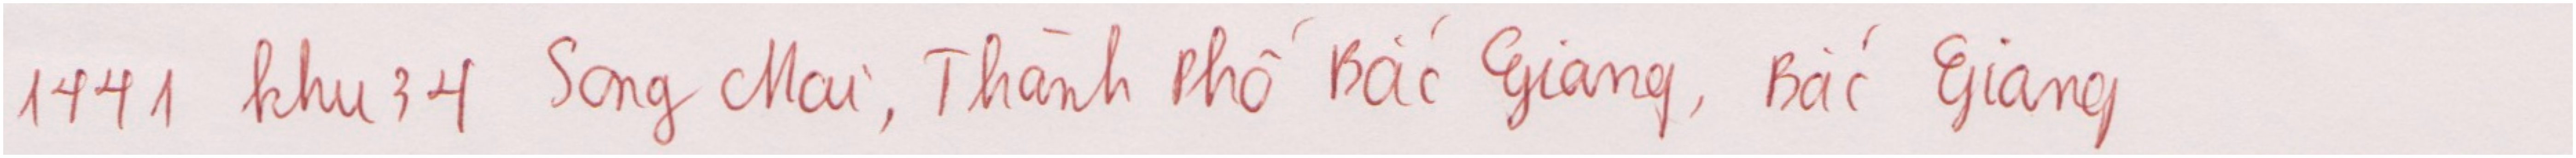

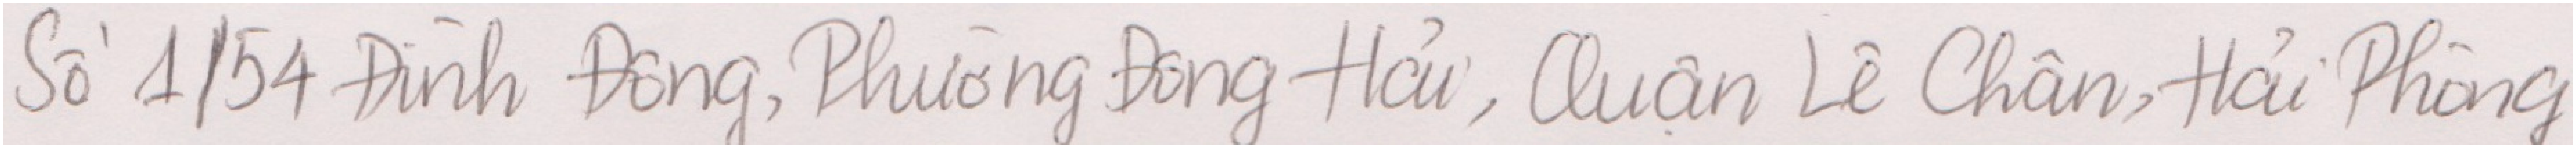

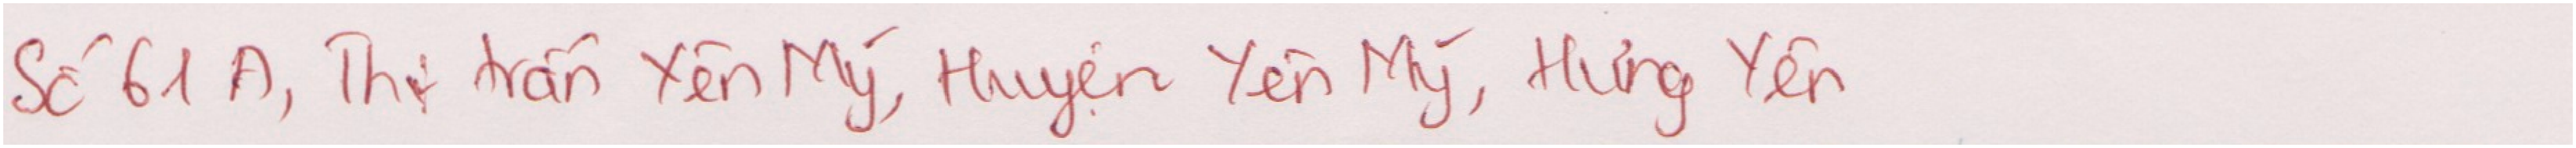

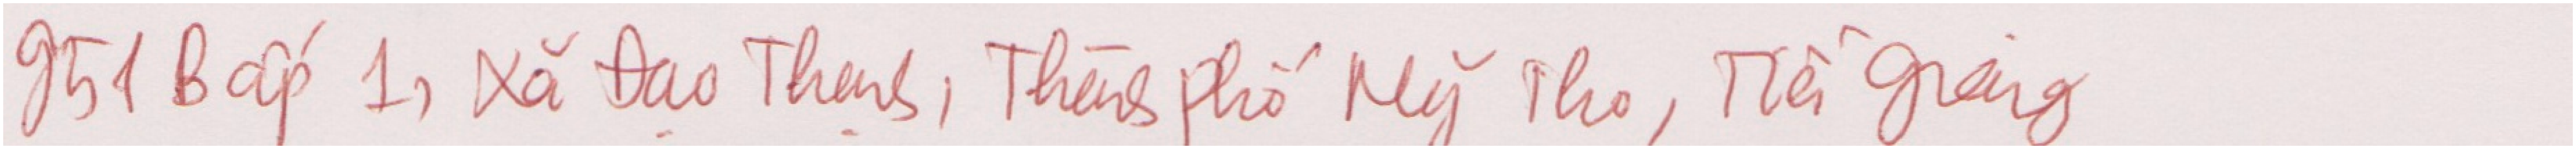

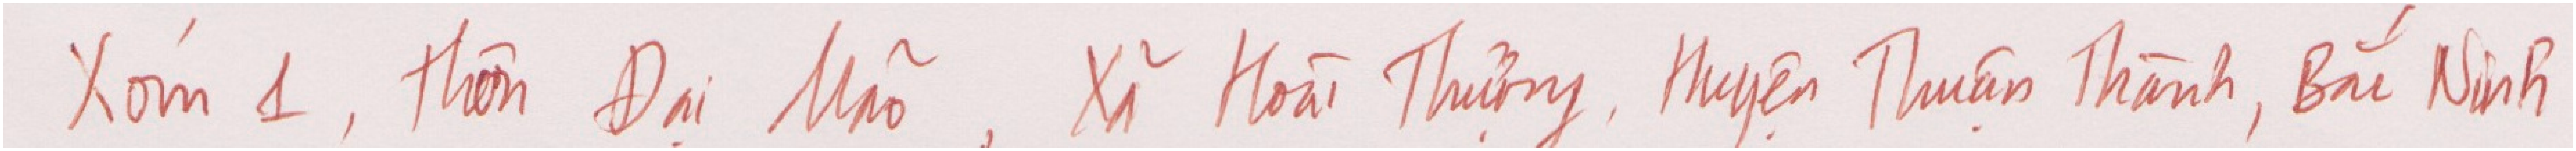

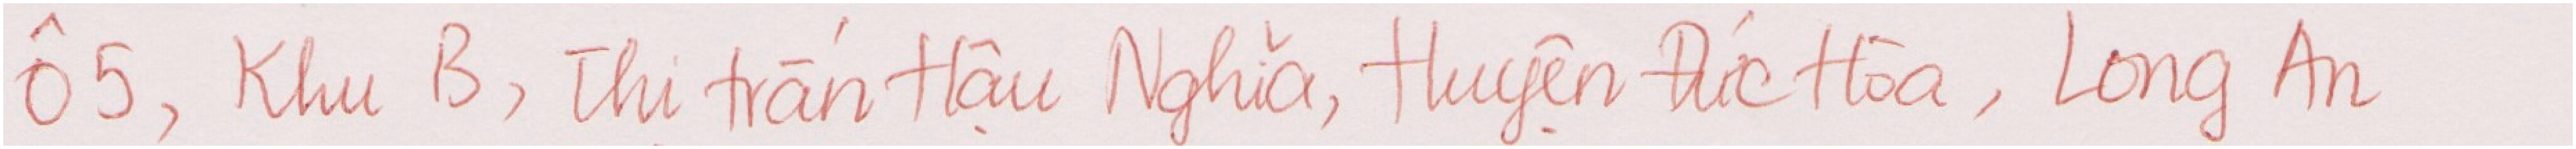

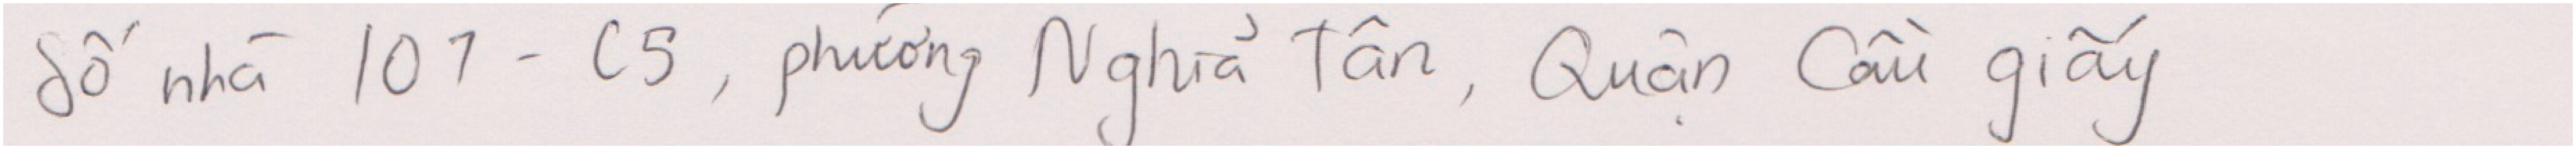

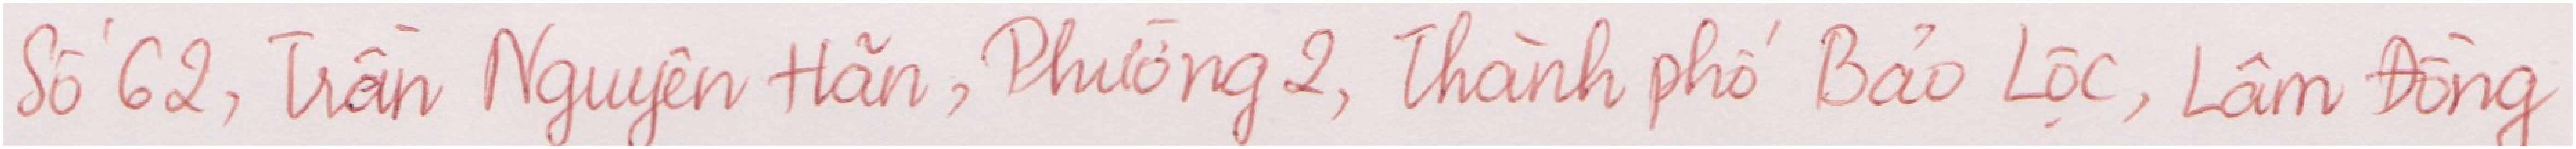

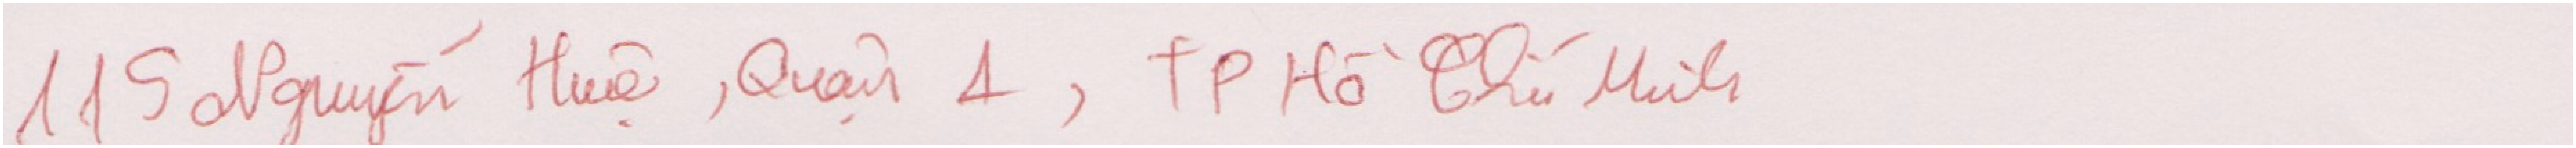

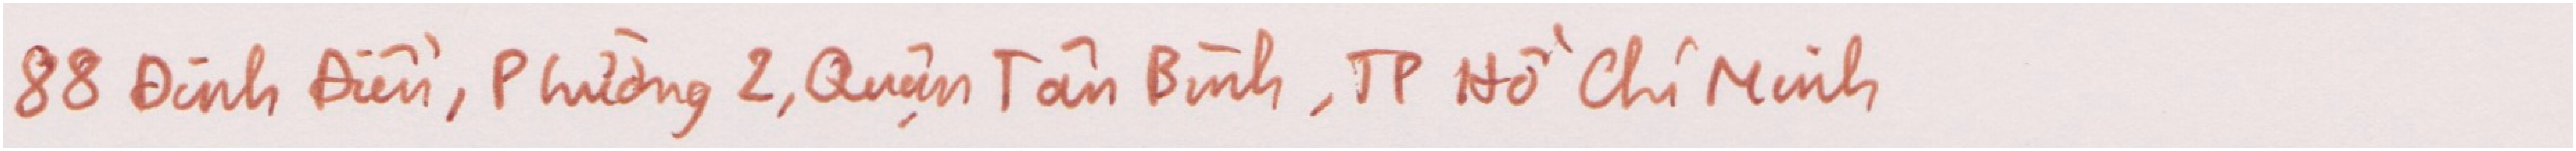

In [0]:
for i in train_image_paths[:10]:
    show_batch(i)

## LOAD JSON LABEL FILES

In [0]:
import json
with open("/content/drive/My Drive/raw/train/labels.json", encoding="utf8") as json_file:
    train_labels = json.load(json_file)
with open("/content/drive/My Drive/raw/test/labels.json", encoding="utf8") as json_file:
    test_labels = json.load(json_file)

In [0]:
# Define unique char list
char = []
for item in train_labels:
    for i in train_labels[item]:
        if i not in char:
            char.append(i)
for item in test_labels:
    for i in test_labels[item]:
        if i not in char:
            char.append(i)

In [0]:
len(char)

142

In [0]:
# Missing some letters.just fill and sort it
char = char + ['ÁÃÀẢẤẠ']
char = ''.join(sorted(char))

In [0]:
# Create function encode label
def encode_to_labels(txt):
    # encoding each output word into digits of indexes
    dig_lst = []
    for index, chars in enumerate(txt):
        try:
            dig_lst.append(char.index(chars))
        except:
            print(chars)
        
    return dig_lst

## NOW WE PREPROCESS DATA AND PREPARE DATA FOR TRAINING MODEL

In [0]:
path = '/content/drive/My Drive/raw/train'
 

# lists for training dataset
training_img = []
training_txt = []
train_input_length = []
train_label_length = []
orig_txt = []
 
#lists for validation dataset
valid_img = []
valid_txt = []
valid_input_length = []
valid_label_length = []
valid_orig_txt = []
 
max_label_len = 120 
 
i =1 
 
for root, dirnames, filenames in os.walk(path):
 
    for f_name in fnmatch.filter(filenames, '*.png'):

        # read input image and convert into gray scale image
        img = cv2.cvtColor(cv2.imread(os.path.join(root, f_name)), cv2.COLOR_BGR2GRAY)   
        w, h = img.shape
        # just basic and simple preprocess data
        img = cv2.GaussianBlur(img, (11,11), 0)
        img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 3)
        
        # add padding to image at the bottom of the image if the image is not tall enough
        if w < 128:
            add_zeros = np.ones((128-w, h))*1
            img = np.concatenate((img, add_zeros))
 
        # add padding at the end of the image if the image is not long enough
        if h < 2000:
            add_zeros = np.ones((128, 2000-h))*1
            img = np.concatenate((img, add_zeros), axis=1)
        img = np.expand_dims(img , axis = 2)
        
        # Normalize each image
        img = img/255.
        
        # get the text from the image, our label
        txt = train_labels[str(f_name)]
           
           
        # split the data into validation and training dataset as 10% and 90% respectively
        if i%10 == 0: 
            valid_orig_txt.append(txt)   
            valid_label_length.append(len(txt))
            
            # append max label length 
            valid_input_length.append(max_label_len)
            valid_img.append(img)
            
            # convert words to digits based on charlist
            valid_txt.append(encode_to_labels(txt))
        else:
            orig_txt.append(txt)   
            train_label_length.append(len(txt))
            
            # append max label length 
            train_input_length.append(max_label_len)
            training_img.append(img)
            
            # convert words to digits based on char list
            training_txt.append(encode_to_labels(txt)) 
        i +=1

In [0]:
train_padded_txt = pad_sequences(training_txt, maxlen=max_label_len, padding='post', value = 0)
valid_padded_txt = pad_sequences(valid_txt, maxlen=max_label_len, padding='post', value = 0)

## TIME FOR MODEL.

In [0]:
# OUR FULL MODEL OF CRNN AND LSTM

# input with shape of height=128 and width=2000 
inputs = Input(shape=(128,2000,1))
 
# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)

# poolig layer with kernel size (2,2) to make the height/2 and width/2
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
 
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)

# poolig layer with kernel size (2,2) to make the height/2 and width/2
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
 
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
batch_norm_3 = BatchNormalization()(conv_3)

conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(batch_norm_3)

# poolig layer with kernel size (2,2) to make the height/2
pool_4 = MaxPool2D(pool_size=(2, 2))(conv_4)
 
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)

# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)

# poolig layer with kernel size (2,2) to make the height/2
pool_6 = MaxPool2D(pool_size=(2, 2))(batch_norm_6)


conv_7 = Conv2D(512, (2,2), activation = 'relu', padding='same')(pool_6)
pool_7 = MaxPool2D(pool_size=(2, 1))(conv_7)

conv_8 = Conv2D(512, (2,2), activation = 'relu', padding='same')(pool_7)
batch_norm_8 = BatchNormalization()(conv_8)
pool_8 = MaxPool2D(pool_size=(3, 1))(batch_norm_8)
 
# # to remove the first dimension of one: (1, 31, 512) to (31, 512) 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(pool_8)
 
# # # bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(blstm_1)

# # this is our softmax character proprobility with timesteps (31, 63)
outputs = Dense(len(char)+1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

In [0]:
# Check summary of act model.we well use this later on for check the result and effiency of trained model
act_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 2000, 1)]    0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 2000, 64)     640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 1000, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 1000, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 500, 128)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 500, 256)      295168    
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 500, 256)      1024  

## ADD CTC TO MODEL

In [0]:
### ctc definition part 
"""
The reason why we use ctc_batch_cost instead of ctc_cost because
In batch cost, the program managed to mask out padded sequence using label_length, 
So the cost won't include the padding 0 section.
"""

"""
The way CTC is modelled currently in Keras is that you need to implement the loss function as a layer, you did that already (loss_out). 
Your problem is that the inputs you give that layer are not tensors from Theano/TensorFlow but numpy arrays.
To change that one option is to model these values as inputs to your model.
That is why we need to manually create Input for labels, input length and label_length.
"""

# define the label input shape for ctc
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')

"""
where input_length and label_length are constants you created previously
the easiest way here is to have a fixed batch size in training 
the lengths should have the same batch size (see shapes in the link for ctc_cost)   
"""

# define the length of input and label for ctc
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
 
# define a ctc lambda function to take arguments and return ctc_bach_cost
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    """
    labels: tensor (number of samples, max_string_length) containing the truth labels.
    y_pred: tensor (number of samples, time_steps, num_character_labels) containing the prediction, or output of the softmax.
    input_length: tensor (number of samples, 1) containing the sequence length for each batch item in y_pred.
    label_length: tensor (number of samples, 1) containing the sequence length for each batch item in y_true.
    """
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
 
# out loss function (just take the inputs and put it in our ctc_batch_cost)
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

In [0]:
# ready ctc loss function and optimizers
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')

# ready out check point save file
filepath="best_model_22000.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [0]:
# ready our training data
training_img = np.array(training_img)
train_input_length = np.array(train_input_length)  # must be equal length to T timesteps = 31
train_label_length = np.array(train_label_length)  # different length

# ready our test data
valid_img = np.array(valid_img)
valid_input_length = np.array(valid_input_length) # must be equal length to T timesteps = 31
valid_label_length = np.array(valid_label_length) # different length

In [0]:
train_input_length

array([120, 120, 120, ..., 120, 120, 120])

In [0]:
valid_input_length

array([120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 12

In [0]:
batch_size = 32
epochs = 60
model.fit(x=[training_img, train_padded_txt, train_input_length, train_label_length],
          y=np.zeros(len(training_img)),
          batch_size=batch_size, epochs = epochs, 
          validation_data = ([valid_img, valid_padded_txt, valid_input_length, valid_label_length], 
                             [np.zeros(len(valid_img))]), verbose = 1, callbacks = callbacks_list)

Epoch 1/60
52/52 [==============================] - ETA: 0s - loss: 212.1366
Epoch 00001: val_loss improved from inf to 203.19920, saving model to best_model_22000.hdf5
52/52 [==============================] - 40s 775ms/step - loss: 212.1366 - val_loss: 203.1992
Epoch 2/60
52/52 [==============================] - ETA: 0s - loss: 153.3328
Epoch 00002: val_loss did not improve from 203.19920
52/52 [==============================] - 34s 654ms/step - loss: 153.3328 - val_loss: 248.7951
Epoch 3/60
52/52 [==============================] - ETA: 0s - loss: 96.4553
Epoch 00003: val_loss did not improve from 203.19920
52/52 [==============================] - 34s 654ms/step - loss: 96.4553 - val_loss: 291.8314
Epoch 4/60
52/52 [==============================] - ETA: 0s - loss: 62.9534
Epoch 00004: val_loss did not improve from 203.19920
52/52 [==============================] - 34s 654ms/step - loss: 62.9534 - val_loss: 317.9690
Epoch 5/60
52/52 [==============================] - ETA: 0s - loss: 4

## REACH VAL LOSS = 11 ,QUITE GOOD RIGHT?

## TIME FOR THE TRUTH.LET SEE

In [0]:
# load the saved best model weights
act_model.load_weights('best_model_22000_11.hdf5')

# predict outputs on validation images
prediction = act_model.predict(valid_img[:10])

In [0]:
prediction.shape

(10, 125, 149)

In [0]:
out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)[0][0])
 
# see the results
i = 0
for x in out:
    print("original_text =  ", valid_orig_txt[i])
    print("predicted text = ", end = '')
    for p in x:  
        if int(p) != -1:
            print(char[int(p)], end = '')       
    print('\n')
    i+=1

original_text =   88 Đinh Điền, Phường 2, Quận Tân Bình, TP Hồ Chí Minh
predicted text = 88 Đình Điền, Phường 2, Quận Tân Bình, TP Hồ Chí Minh

original_text =   Thôn Văn Xá, Xã Nhị Khê, Huyện Thường Tín, Hà Nội
predicted text = Thôn Văn Xá, Xã Nhị Khê, Huyện Thường Tín, Hà Nội

original_text =   Số 7 Tổ 1, P. Lương Khánh Thiện, Thành Phố Phủ Lý, Hà Nam
predicted text = Số 7, Tổ 1, P. Lưng Khanh Thiện, Thành phố Phủ Lý, Hà Nam

original_text =   Thị Trấn Cao Thượng, Huyện Tân Yên, Bắc Giang
predicted text = Thị Trấn Cao Trưng, Huyện Tân Yên, Bắc Giang

original_text =   Thôn Cán Khê, Xã Nguyên Khê, Huyện Đông Anh, Hà Nội
predicted text = Thôn Cá Khê, Xã Nuyên Khê, Huyện Đng Anh, Hà Nội

original_text =   88 Bành Văn Trân, Phường 7, Quận Tân Bình, TP Hồ Chí Minh
predicted text = 88 Bành Văn Trân, Phường 7, Quận Tân Bình, TP Hồ Chí Minh

original_text =   Thôn 5, Xã Ia Le, Huyện Chư Pưh, Gia Lai
predicted text = Thôn 5, Xã xa La, Huyện Chư Bính, Gia Lai

original_text =   Khu 5, xã Tiên 

## TAKE AN EXAMPLE FROM TEST DATA AND CHECK HOW GOOD IS THE MODEL

In [0]:
def preprocess(path):
    image = cv2.imread(path)
    # change it to grey 1 channel
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # blur it
    blurred = cv2.GaussianBlur(gray, (9,9), 0)
    # Threshold the image using adapative threshold
    img = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 3)
    w, h = img.shape         
    # add padding to image at the bottom of the image if the image is not tall enough
    if w < 128:
        add_zeros = np.ones((128-w, h))*1
        img = np.concatenate((img, add_zeros))
    # add padding at the end of the image if the image is not long enough
    if h < 2000:
        add_zeros = np.ones((128, 2000-h))*1
        img = np.concatenate((img, add_zeros), axis=1)
    img = np.expand_dims(img , axis = 2)  
    # Normalize each image
    img = img/255.
    return img

In [0]:
im = preprocess("/content/drive/My Drive/raw/test/0389_tests.png")
im = np.expand_dims(im , axis = 0)

In [0]:
prediction = act_model.predict(im)

In [0]:
out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)[0][0])
 
# see the results
i = 0
for x in out:
    print("predicted text = ", end = '')
    for p in x:  
        if int(p) != -1:
            print(char[int(p)], end = '')       
    print('\n')
    i+=1

predicted text = Số 20 Đường Tân Đức Thợng, Phường Hàng Bột, Quận Đng Đa, Hà Nội

